In [8]:
import os
import re
import pandas as pd
import numpy as np
from pdfminer.high_level import extract_text
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Skill set
SKILL_SET = {'tensorflow', 'keras', 'pytorch', 'machine learning', 'deep learning', 'flask', 'streamlit', 'react', 'django', 'node js', 'react js', 'php', 'laravel', 'magento', 'wordpress', 'javascript', 'angular js', 'c#', 'android', 'android development', 'flutter', 'kotlin', 'xml', 'kivy', 'ios', 'ios development', 'swift', 'cocoa', 'cocoa touch', 'xcode', 'ux', 'adobe xd', 'figma', 'zeplin', 'balsamiq', 'ui', 'prototyping', 'wireframes', 'storyframes', 'adobe photoshop', 'photoshop', 'editing', 'adobe illustrator', 'illustrator', 'adobe after effects', 'after effects', 'adobe premier pro', 'premier pro', 'adobe indesign', 'indesign', 'wireframe', 'solid', 'grasp', 'user research', 'user experience', 'aws', 'google cloud platform', 'microsoft azure', 'docker', 'kubernetes', 'jenkins', 'github actions', 'terraform', 'ci/cd', 'ansible', 'apache spark', 'apache kafka', 'hadoop', 'airflow', 'snowflake', 'etl', 'dbt', 'pandas', 'numpy', 'mysql', 'postgresql', 'mongodb', 'sqlite', 'redis', 'firebase', 'cassandra', 'elasticsearch', 'next.js', 'vue.js', 'svelte', 'tailwind css', 'bootstrap', 'rest api', 'graphql', 'websockets', 'typescript', 'go', 'rust', 'scala', 'ruby', 'bash', 'matlab', 'opencv', 'transformers', 'hugging face', 'nltk', 'spacy', 'scikit-learn', 'langchain', 'llm', 'generative ai', 'chatgpt', 'prompt engineering', 'owasp', 'penetration testing', 'burp suite', 'wireshark', 'ethical hacking', 'kali linux', 'selenium', 'junit', 'cypress', 'postman', 'testng', 'appium', 'jira', 'trello', 'asana', 'notion', 'confluence', 'slack', 'agile', 'scrum', 'blender', 'canva', 'sketch', 'invision', 'reactjs', 'node.js', 'angular', 'vue', 'machine-learning', 'deep-learning', 'gcp', 'azure', 'ui/ux', 'adobe premiere', 'adobe aftereffects'}

ROLE_SKILL_MAP = {
    "Data Scientist": {"pandas", "numpy", "scikit-learn", "tensorflow", "keras", "pytorch", "machine learning", "deep learning", "matplotlib"},
    "Backend Developer": {"django", "flask", "node js", "php", "laravel", "express", "mongodb", "mysql", "postgresql", "graphql"},
    "Frontend Developer": {"react", "react js", "angular js", "vue.js", "svelte", "html", "css", "javascript", "tailwind css", "bootstrap"},
    "DevOps Engineer": {"docker", "kubernetes", "jenkins", "github actions", "terraform", "aws", "azure", "gcp", "ci/cd", "ansible"},
    "Mobile Developer": {"flutter", "kotlin", "android", "ios", "swift", "xcode", "android development", "ios development"},
    "UI/UX Designer": {"figma", "adobe xd", "wireframes", "prototyping", "user experience", "sketch", "invision"},
    "Security Engineer": {"penetration testing", "owasp", "burp suite", "wireshark", "ethical hacking", "kali linux"},
    "Tester / QA Engineer": {"selenium", "junit", "cypress", "testng", "appium", "postman"}
}

In [9]:
# Extract text from PDFs

def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

In [10]:
# Clean text
def clean_text(text):
    return re.sub(r'\s+', ' ', text).strip()

In [11]:
def extract_name(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            logging.info(f"Detected name entity: {ent.text}")
            return ent.text
    return "N/A"

def extract_email(text):
    matches = re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', text)
    return matches[0] if matches else "N/A"

def extract_phone(text):
    matches = re.findall(r'(\+?\d[\d\s\-()]{7,}\d)', text)
    return re.sub(r'[^\d+]', '', matches[0]) if matches else "N/A"

def extract_skills(text):
    doc = nlp(text.lower())
    lemmatized = {token.lemma_ for token in doc if not token.is_stop and token.is_alpha}
    matched_skills = list(SKILL_SET.intersection(lemmatized))
    logging.info(f"Extracted skills: {matched_skills}")
    return matched_skills

In [12]:
# Paths
train_folder = "resumes_train"
test_folder = "resumes_test"

In [3]:
import sys
!{sys.executable} -m pip install imbalanced-learn


  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\keepu\Downloads\Analysing-of-Resumes\myenv\Scripts\python.exe -m pip install --upgrade pip


In [13]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
import pickle

# Load PDF data
texts, filenames = [], []

for filename in os.listdir(train_folder):
    if filename.endswith(".pdf"):
        path = os.path.join(train_folder, filename)
        text = extract_text_from_pdf(path)
        texts.append(clean_text(text))
        filenames.append(filename)

# Dummy labels (for demonstration); replace with actual labels if available
labels = [1 if i % 2 == 0 else 0 for i in range(len(texts))]

# Tokenization
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = 200
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Balance dataset
X = np.array(padded_sequences)
y = np.array(labels)

ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

print(f"Original dataset size: {len(y)}")
print(f"Balanced dataset size: {len(y_balanced)}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Build Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save model and tokenizer
model.save("resume_model.h5")
with open("tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Original dataset size: 2148
Balanced dataset size: 2148


C:\Users\keepu\Downloads\Analysing-of-Resumes\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5080 - loss: 0.6942 - val_accuracy: 0.4953 - val_loss: 0.6932
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.4953 - val_loss: 0.6932
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5031 - loss: 0.6930 - val_accuracy: 0.5302 - val_loss: 0.6931
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5215 - loss: 0.6927 - val_accuracy: 0.5209 - val_loss: 0.6930
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5481 - loss: 0.6916 - val_accuracy: 0.5372 - val_loss: 0.6930
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5537 - loss: 0.6909 - val_accuracy: 0.5140 - val_loss: 0.6935
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5709 - loss: 0.6893 - val_accuracy: 0.5279 - val_loss: 0.6931
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5817 - loss: 0.6874 - val_accuracy: 0.4953 - val_

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5332 - loss: 0.6877 
Test Accuracy: 51.86%


In [14]:
from tensorflow.keras.models import load_model

model = load_model("resume_model.h5")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 16)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,291 (63.64 KB)

 Trainable params: 16,289 (63.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np

# ----- Assuming texts and labels are already available -----
# texts = [...]
# labels = [...]

# Tokenization
vocab_size = 5000
max_length = 300  # Increase token length
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Convert to arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# ----- Improved Model -----
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save model and tokenizer
model.save("resume_model_upgraded.h5")
import pickle
with open("tokenizer_upgraded.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

loss, accuracy = model.evaluate(X_train, y_train)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.4608 - loss: 0.6948 - val_accuracy: 0.5070 - val_loss: 0.6930
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.5219 - loss: 0.6920 - val_accuracy: 0.5047 - val_loss: 0.6931
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5526 - loss: 0.6899 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.6139 - loss: 0.6835 - val_accuracy: 0.5093 - val_loss: 0.6945
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.6503 - loss: 0.6658 - val_accuracy: 0.5326 - val_loss: 0.6909
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.7273 - loss: 0.5893 - val_accuracy: 0.5209 - val_loss: 0.7668
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8286 - loss: 0.4179 - val_accuracy: 0.5279 - val_loss: 1.0509
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9168 - loss: 0.2441 - val_accuracy: 0

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9947 - loss: 0.0173
Test Accuracy: 99.42%
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5194 - loss: 2.0854
Test Accuracy: 52.56%


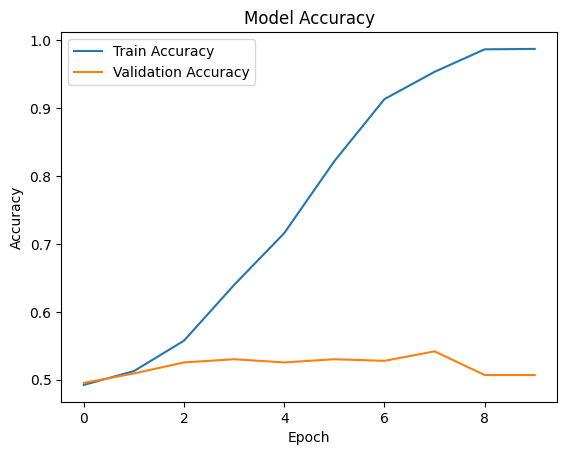

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9811 - loss: 0.0527 - val_accuracy: 0.5140 - val_loss: 1.9968
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9928 - loss: 0.0309 - val_accuracy: 0.4907 - val_loss: 2.5138
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9952 - loss: 0.0188 - val_accuracy: 0.5070 - val_loss: 2.6526
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9895 - loss: 0.0360 - val_accuracy: 0.5209 - val_loss: 2.9134


In [25]:
from collections import Counter
print(Counter(y_train))


Counter({np.int64(0): 861, np.int64(1): 857})


In [26]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"New Test Accuracy: {accuracy*100:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5196 - loss: 1.9926
New Test Accuracy: 51.40%


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [29]:
from collections import Counter
print(Counter(labels))


Counter({1: 1074, 0: 1074})


In [34]:
# Infer labels using keyword-based heuristic (temporary, replace with real labels later)
def infer_label(text):
    text = text.lower()
    must_have = ['machine learning', 'project', 'python', 'experience']
    good_signs = ['intern', 'bachelor', 'tensorflow', 'keras']
    bad_signs = ['fresher', 'no experience', 'hsc', 'intermediate', 'school']

    score = 0
    for keyword in must_have:
        if keyword in text:
            score += 2
    for keyword in good_signs:
        if keyword in text:
            score += 1
    for keyword in bad_signs:
        if keyword in text:
            score -= 2

    return 1 if score >= 3 else 0

# Load texts and generate labels
texts = []
filenames = []
labels = []

for filename in os.listdir("resumes_train"):  # ← replace with your actual folder path
    if filename.endswith(".pdf"):
        path = os.path.join("resumes_train", filename)
        text = clean_text(extract_text_from_pdf(path))
        label = infer_label(text)

        texts.append(text)
        filenames.append(filename)
        labels.append(label)

print(f"Loaded {len(texts)} resumes. Positive samples: {sum(labels)}, Negative samples: {len(labels) - sum(labels)}")


Loaded 2148 resumes. Positive samples: 1516, Negative samples: 632


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Tokenize the text
vocab_size = 1000
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy array
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels
)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential([
    Embedding(input_dim=1000, output_dim=16, input_length=200),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    batch_size=32
)


C:\Users\keepu\Downloads\Analysing-of-Resumes\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6914 - loss: 0.6672 - val_accuracy: 0.7047 - val_loss: 0.6085
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7054 - loss: 0.6073 - val_accuracy: 0.7047 - val_loss: 0.6038
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7148 - loss: 0.5993 - val_accuracy: 0.7047 - val_loss: 0.5956
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7089 - loss: 0.5872 - val_accuracy: 0.7047 - val_loss: 0.5697
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7111 - loss: 0.5551 - val_accuracy: 0.7070 - val_loss: 0.5354
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7150 - loss: 0.5213 - val_accuracy: 0.7349 - val_loss: 0.5194
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7404 - loss: 0.5067 - val_accuracy: 0.7791 - val_loss: 0.5129
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7771 - loss: 0.4634 - val_accuracy: 0.7744 - val_loss:

In [37]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save model and tokenizer
model.save("resume_model_balanced.h5")
import pickle
with open("tokenizer_balanced.pickle", "wb") as f:
    pickle.dump(tokenizer, f)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7694 - loss: 0.5106 


Test Accuracy: 77.67%


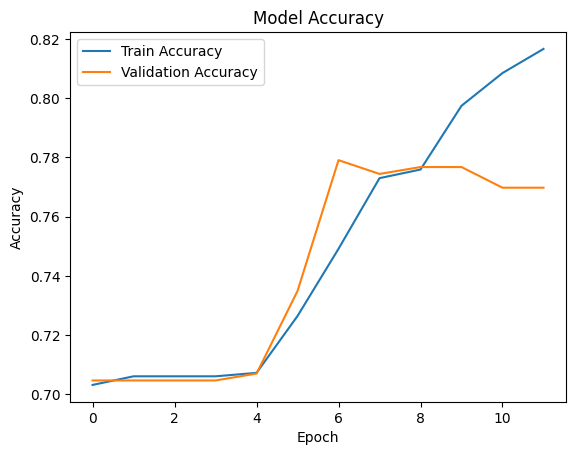

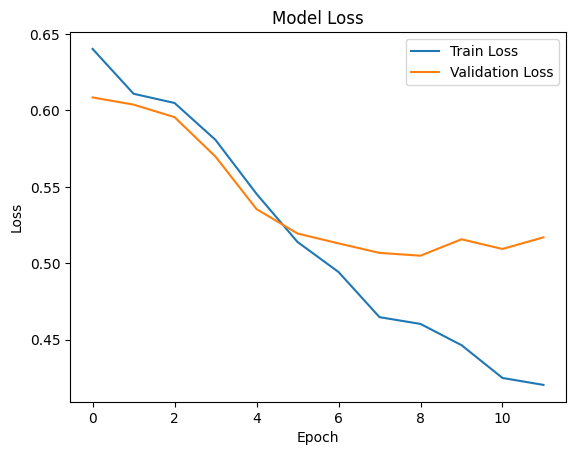

In [38]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


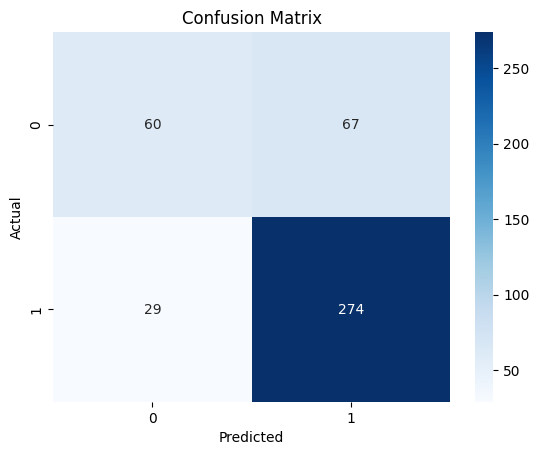

              precision    recall  f1-score   support

           0       0.67      0.47      0.56       127
           1       0.80      0.90      0.85       303

    accuracy                           0.78       430
   macro avg       0.74      0.69      0.70       430
weighted avg       0.77      0.78      0.76       430



In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [40]:
def predict_resume_class(pdf_path):
    text = clean_text(extract_text_from_pdf(pdf_path))
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=200)
    pred = model.predict(padded)[0][0]
    return "Accepted" if pred > 0.5 else "Not Accepted"


In [41]:
from tensorflow.keras.models import load_model
import pickle

# Load trained model and tokenizer
model = load_model("resume_model_balanced.h5")
with open("tokenizer_balanced.pickle", "rb") as f:
    tokenizer = pickle.load(f)


In [42]:
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

def extract_text_from_pdf(path):
    from PyPDF2 import PdfReader
    reader = PdfReader(path)
    text = " ".join([page.extract_text() or "" for page in reader.pages])
    return text

def clean_text(text):
    import re
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()


In [43]:
unseen_folder = "resumes"  # 🔁 Replace this with your folder path

filenames = []
results = []

for filename in os.listdir(unseen_folder):
    if filename.endswith(".pdf"):
        path = os.path.join(unseen_folder, filename)
        raw_text = extract_text_from_pdf(path)
        clean = clean_text(raw_text)
        seq = tokenizer.texts_to_sequences([clean])
        padded = pad_sequences(seq, maxlen=200)
        pred = model.predict(padded)[0][0]
        label = "Accepted" if pred > 0.5 else "Not Accepted"
        
        filenames.append(filename)
        results.append(label)

# Save results to CSV
import pandas as pd
df = pd.DataFrame({
    "Filename": filenames,
    "Prediction": results
})
df.to_csv("unseen_predictions.csv", index=False)
print("Saved predictions to unseen_predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Saved predictions to unseen_predictions.csv
